<a href="https://colab.research.google.com/github/DanieleCecca/Where-to-land-a-drone/blob/main/Where_to_land_your_drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Where to land your drone

Daniele Cecca

Matr. 914358

MSc Artificial Intelligence for Science and Technology

Email: d.cecca@campus.unimib.it

The following project involves the development of a system capable of segmenting an image taken from a drone and detecting the best landing spot.

The project is divided into three main parts:

- **Dataset**: This section explores the dataset and describes how it is divided into training and test sets.

- **Segmentation**: This part covers the design, development, and comparison of various state-of-the-art segmentation models.

- **Best Spot Identification**: This section details the method used to identify the optimal landing spot and its detection.

## Imports and environment setup

In [ ]:
!pip install opencv-python -q
!pip install -qq -U wandb
!pip install -U tensorboard-plugin-profile
!pip install keras-flops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
#imports to manage the data
import numpy as np
import pandas as pd
import numpy as np
import cv2
import random
import os

#imports to plot graphs
import matplotlib.pyplot as plt
import seaborn as sns

#imports to manage and develop DL models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from sklearn.model_selection import train_test_split
from tensorflow.keras import ops
from tensorflow.keras.models import load_model
import shutil


#imports to use weights and biases
import wandb
from wandb.integration.keras import WandbMetricsLogger

#imports to evauale the results of model inference durig test
from sklearn.metrics import accuracy_score, precision_score,\
recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

#imports best spot
from sklearn.cluster import AgglomerativeClustering


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
wandb.login()
os.environ["WANDB_PROJECT"] = "Environment-Segmentation"

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ceccadaniele00 (SanRaffaele) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Constants

In [ ]:
DATA_CLASS='/content/drive/MyDrive/project24-25/NewDataset/class_dict_seg.csv'

In [ ]:
DATA_ORIGINAL='/content/drive/MyDrive/environment/project24-25/Dataset/original_images'

In [ ]:
DATA_MASK='/content/drive/MyDrive/environment/project24-25/Dataset/label_images_semantic'

In [ ]:
DATA_RGB_MASK='/content/drive/MyDrive/environment/project24-25/Dataset/RGB_color_image_masks'

In [ ]:
CROPPED_DATA_ORIGINAL='/content/drive/MyDrive/project24-25/NewDataset/cropped_images'

In [ ]:
CROPPED_DATA_MASK='/content/drive/MyDrive/project24-25/NewDataset/cropped_mask'

In [ ]:
RESIZED_DATA_ORIGINAL='/content/drive/MyDrive/project24-25/NewDataset/resized_images'

In [ ]:
RESIZED_DATA_MASK='/content/drive/MyDrive/project24-25/NewDataset/resized_mask'

In [ ]:
RESIZED_DATA_RGB_MASK='/content/drive/MyDrive/project24-25/NewDataset/resized_rgb_mask'

In [ ]:
DATA_AUGMENTED='/content/drive/MyDrive/project24-25/NewDataset/augmented_images'

In [ ]:
DATA_MASK_AUGMENTED='/content/drive/MyDrive/project24-25/NewDataset/augmented_images_mask'

In [ ]:
MODELS='/content/drive/MyDrive/project24-25/Models'

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    }
}

In [ ]:
parameters_dict = {
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    'batch_size':{
        'values':[1, 5, 10]
    },
    'epoch': {
        'value': 100
        },
    'lr': {
        'values': [0.001, 0.0001]
        }
}

sweep_config['parameters'] = parameters_dict

## Functions

### Functions data

In [ ]:
def info_images(folder_name):
    info = {
        'img_name': [],
        'shape': []
    }
    for img_name in os.listdir(folder_name):
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)

        info['img_name'].append(img_name)
        info['shape'].append(img.shape)

    return info

In [ ]:
def count_labels(folder_name):
    label_counts = {}

    for img_name in os.listdir(folder_name):
        img_path = os.path.join(folder_name, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        unique_values, counts = np.unique(img, return_counts=True)

        for val, count in zip(unique_values, counts):
            if val not in label_counts:
                label_counts[val] = 0
            label_counts[val] += count
    return label_counts

In [ ]:
def resize_images(folder_name, new_folder, height, width):
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    i = 0
    for img_name in os.listdir(folder_name):
        img_path = os.path.join(folder_name, img_name)
        img = cv2.imread(img_path)
        new_size = (width, height)

        resized_img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)

        new_img_path = os.path.join(new_folder, img_name)
        cv2.imwrite(new_img_path, resized_img)
        i += 1
        print(f"{i}. {img_name} salvata con resize")

In [ ]:
def crop_images(original_images_dir, mask_images_dir, new_original_dir, new_mask_dir, size):
    if not os.path.exists(new_original_dir):
        os.makedirs(new_original_dir)

    if not os.path.exists(new_mask_dir):
        os.makedirs(new_mask_dir)

    i = 0
    for img_name in os.listdir(original_images_dir):
        img_path = os.path.join(original_images_dir, img_name)
        mask_path = os.path.join(mask_images_dir, img_name[:-3]+'png')

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)


        h, w = img.shape[:2]
        scale = 1024.0 / max(h, w)
        new_w = int(w * scale)
        new_h = int(h * scale)

        img = cv2.resize(img, (new_w, new_h))
        mask = cv2.resize(mask, (new_w, new_h))


        #croppa l'immagine in una dimesione 256 x 256 casualmente
        h, w = img.shape[:2]
        x = random.randint(0, new_w - size)
        y = random.randint(0, new_h - size)
        cropped_img = img[y:y+size, x:x+size]
        cropped_mask= mask[y:y+size, x:x+size]

        base_name, ext = os.path.splitext(img_name)
        new_img_name = f"{base_name}_crop{ext}"
        new_mask_name = f"{base_name}_crop.png"
        new_img_path = os.path.join(new_original_dir, new_img_name)
        new_mask_path = os.path.join(new_mask_dir, new_mask_name)

        cv2.imwrite(new_img_path, cropped_img)
        cv2.imwrite(new_mask_path, cropped_mask)
        i += 1
        print(f"{i}. {img_name} salvata con crop")

In [ ]:
def visualize_images(folder_name,rows=5,columns=4):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        data=pd.Series(os.listdir(folder_name))
        img_name=data.sample(1).iloc[0]
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
def match_rgb2label(rgb_mask_folder, gray_mask_folder, csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    if 'label' not in df.columns:
        df['label'] = None

    for img_name in os.listdir(rgb_mask_folder):
        print(f"Processing {img_name}...")
        img_rgb_path = os.path.join(rgb_mask_folder, img_name)
        img_gray_path = os.path.join(gray_mask_folder, img_name)

        img_rgb = cv2.imread(img_rgb_path)
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        img_gray = cv2.imread(img_gray_path, cv2.IMREAD_GRAYSCALE)


        if img_rgb is None or img_gray is None:
            print(f"Immagine non trovata o non valida: {img_name}")
            continue

        h, w = img_gray.shape
        for row in range(h):
            for col in range(w):
                label = img_gray[row, col]
                rgb = img_rgb[row, col]

                if label in df['label'].values:
                    continue

                match = df[
                    (df['r'] == rgb[0]) &
                    (df['g'] == rgb[1]) &
                    (df['b'] == rgb[2]) &
                    (df['label'].isna())
                ]

                if not match.empty:
                    df.loc[match.index, 'label'] = label
                    print(f"Matched RGB {rgb} --> Label {label}")

                if df['label'].notna().all():
                    df.to_csv(csv_path, index=False)
                    print("All labels assigned.")
                    return df

    df.to_csv(csv_path, index=False)
    print("Label matching completed.")
    return df

In [ ]:
def rotated_image(img):
  h,w = img.shape[:2]
  rotation_angle=random.randint(0,360)
  rotation_matrix=cv2.getRotationMatrix2D((w/2,h/2),rotation_angle,1)
  rotated_image=cv2.warpAffine(img,rotation_matrix,(w,h))
  return rotated_image

In [ ]:
def flipped_image(img):
  flipped_image=cv2.flip(img,1) #>0 flip vertical
  return flipped_image

In [ ]:
def change_hsv(img):
  # Converti in HSV
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  h, s, v = cv2.split(hsv)

  # Cambi randomici per i 3 canali
  delta_h = random.randint(-10, 10)     # piccoli cambiamenti per evitare artefatti di colore
  delta_s = random.randint(-50, 50)
  delta_v = random.randint(-50, 50)

  # Applica i cambiamenti con saturazione (limita i valori tra 0 e 255)
  h = cv2.add(h, delta_h)
  s = cv2.add(s, delta_s)
  v = cv2.add(v, delta_v)

  # Ricostruisci HSV e riconverti in BGR
  hsv_modified = cv2.merge((h, s, v))
  bright_image = cv2.cvtColor(hsv_modified, cv2.COLOR_HSV2BGR)

  return bright_image

In [ ]:
def add_blur(img):
  h,w=5,5
  blur_image=cv2.blur(img,(h,w))
  return blur_image

In [ ]:
def add_gaussian_noise(img):
  mean=0
  st=0.7
  gauss = np.random.normal(mean,st,img.shape)
  gauss = gauss.astype('uint8')
  img = cv2.add(img,gauss)
  return img

In [ ]:
def random_cutout(img, num_masks=5, mask_size_ratio=0.2):
    out = img.copy()
    h, w = img.shape[:2]
    mask_w = int(w * mask_size_ratio)
    mask_h = int(h * mask_size_ratio)

    for _ in range(num_masks):
        x1 = random.randint(0, w - mask_w)
        y1 = random.randint(0, h - mask_h)
        x2 = x1 + mask_w
        y2 = y1 + mask_h
        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 0, 0), thickness=-1)
    return out

In [ ]:
def augment_data(original_images_dir, mask_images_dir, new_original_dir, new_mask_dir):
    transformations = [add_gaussian_noise, add_blur, change_hsv, flipped_image, rotated_image, random_cutout]

    for img_name in os.listdir(original_images_dir):
        img_path = os.path.join(original_images_dir, img_name)
        mask_path = os.path.join(mask_images_dir, img_name[:-3]+'png')

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Choose a random transformation
        transform = random.choice(transformations)

        # Apply transformation
        if transform in [flipped_image, rotated_image]:
            img = transform(img)
            mask = transform(mask)
        else:
            # Non-geometric transforms should not be applied to the mask
            # so we just copy the original mask
            img = transform(img)


        # Create new file names (e.g., img_01_aug.jpg)
        base_name, ext = os.path.splitext(img_name)
        new_img_name = f"{base_name}_aug{ext}"
        new_mask_name = f"{base_name}_aug.png"

        # Save augmented image and corresponding mask
        print(new_img_name,new_mask_name)
        cv2.imwrite(os.path.join(new_original_dir, new_img_name), img)
        cv2.imwrite(os.path.join(new_mask_dir, new_mask_name), mask)


### Functions models

In [ ]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        #input img
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = input_img[..., ::-1]  # da BGR a RGB beacuse i used cv2
        if input_img.shape[:2]!=(img_size,img_size):
          input_img=tf_image.resize(input_img,(img_size,img_size),method='nearest')
        input_img = tf_image.convert_image_dtype(input_img, "float32")#normalized/255

        #mask
        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        if target_img.shape[:2]!=(img_size,img_size):
          target_img=tf_image.resize(target_img,(img_size,img_size),method='nearest')
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]


    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [ ]:
def train(X_train, X_val, y_train, y_val, model, config=None):
    with wandb.init(name=model, project="Environment-Segmentation", config=config):
        config = wandb.config

        # Setup data
        train_dataset = get_dataset(config.batch_size, 256, X_train, y_train)
        val_dataset = get_dataset(config.batch_size, 256, X_val, y_val)
        #test_dataset = get_dataset(config.batch_size, 256, X_test, y_test)

        # Setup model
        if model == 'Unet':
            unet_model = UNet(dropout=config.dropout)
        elif model == 'ResUnet':
            unet_model = ResUnet(dropout=config.dropout)
        elif model == 'Segformer':
            unet_model = Segformer(dropout=config.dropout)
        elif model == 'DeepLabV3Plus':
            unet_model = DeeplabV3Plus()
        else:
            raise ValueError("Modello non valido")

        unet_model.compile(
            optimizer=tf.keras.optimizers.AdamW(config.lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Dynamic file and TensorBoard log directory
        model_filename = os.path.join(wandb.run.dir, f"best_model_{wandb.run.id}.keras")
        log_dir = os.path.join(wandb.run.dir, "tensorboard_logs")

        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=model_filename,
                save_best_only=True,
                monitor="val_loss",
                mode="min"
            ),
            WandbMetricsLogger(),

            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                patience=5,
                factor=0.1,
                verbose=1,
                min_lr=1e-6
            ),

            # TensorBoard callback with profiling enabled
            keras.callbacks.TensorBoard(
                log_dir=log_dir,
                histogram_freq=1,
                profile_batch='2,5',
                write_graph=True,
                write_images=True,
                update_freq='epoch'
            ),
        ]

        # Train
        unet_model.fit(
            train_dataset,
            epochs=config.epoch,
            validation_data=val_dataset,
            callbacks=callbacks,
            verbose=1,
        )

        # Save TensorBoard logs as W&B artifact
        artifact = wandb.Artifact(
            name=f"tensorboard-logs-{wandb.run.id}",
            type="tensorboard-logs"
        )
        artifact.add_dir(log_dir)
        wandb.log_artifact(artifact)

### Functions test

In [ ]:
def dice_coefficient(y_true, y_pred, num_classes):

    dice_scores = {}

    for cls in range(num_classes):
        y_true_cls = (y_true == cls).astype(np.uint8)
        y_pred_cls = (y_pred == cls).astype(np.uint8)

        intersection = np.sum(y_true_cls * y_pred_cls)
        denominator = np.sum(y_true_cls) + np.sum(y_pred_cls)

        if denominator == 0:
            dice = 1.0  # Se non ci sono pixel per quella classe in nessuna delle due, consideriamolo perfetto
        else:
            dice = 2.0 * intersection / denominator

        dice_scores[f'dice_class_{cls}'] = dice

    # Macro average (media tra le classi)
    dice_scores['mean_dice'] = np.mean(list(dice_scores.values()))

    return dice_scores

In [ ]:
def evaluate_model(y_true, y_pred,data):
    labels=data['label'].to_list()
    num_classes=len(labels)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    dice = dice_coefficient(y_true, y_pred, num_classes)

    metrics = {
        "accuracy": accuracy_score(y_true_flat, y_pred_flat),
        "precision_macro": precision_score(y_true_flat, y_pred_flat, average='macro', labels=labels, zero_division=0),
        "recall_macro": recall_score(y_true_flat, y_pred_flat, average='macro', labels=labels, zero_division=0),
        "f1_macro": f1_score(y_true_flat, y_pred_flat, average='macro', labels=labels, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true_flat, y_pred_flat, labels=labels),
    }

    return metrics, dice

In [ ]:
def visualize_prediction(image, y_true, y_pred,data, index=0):
    img = image[index]
    gt_mask = y_true[index]
    pred_mask = y_pred[index]

    # Applica colori per ogni classe
    gt_mask_rgb = np.zeros((*gt_mask.shape, 3), dtype=np.uint8)
    pred_mask_rgb = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)

    for label in data['label'].unique():
        color = data[data['label'] == label][['r', 'g', 'b']].values[0]
        color = tuple(color.astype(np.uint8))  # in caso siano float
        gt_mask_rgb[gt_mask == label] = color
        pred_mask_rgb[pred_mask == label] = color

    plt.figure(figsize=(9, 3))

    plt.subplot(1, 3, 1)
    plt.imshow((img*255).astype(np.uint8))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_rgb)
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### Functions land spot

In [ ]:
def gaussian_score(x, mu, sigma):
    return np.exp(-((x - mu) / (2 * sigma))**2)

## Dataset

The dataset used is part of **the Semantic Drone Dataset**, available at http://dronedataset.icg.tugraz.at. It consists of **400 images**, each paired with a corresponding semantic label
map and RGB mask.
In total, the dataset includes **23 distinct semantic regions**

In [ ]:
df_label=pd.read_csv(DATA_CLASS)
df_label

name    r    g    b  label
0     unlabeled    0    0    0    0.0
1    paved-area  128   64  128    1.0
2          dirt  130   76    0    2.0
3         grass    0  102    0    3.0
4        gravel  112  103   87    4.0
5         water   28   42  168    5.0
6         rocks   48   41   30    6.0
7          pool    0   50   89    7.0
8    vegetation  107  142   35    8.0
9          roof   70   70   70    9.0
10         wall  102  102  156   10.0
11       window  254  228   12   11.0
12         door  254  148   12   12.0
13        fence  190  153  153   13.0
14   fence-pole  153  153  153   14.0
15       person  255   22   96   15.0
16          dog  102   51    0   16.0
17          car    9  143  150   17.0
18      bicycle  119   11   32   18.0
19         tree   51   51    0   19.0
20    bald-tree  190  250  190   20.0
21    ar-marker  112  150  146   21.0
22     obstacle    2  135  115   22.0
23  conflicting  255    0    0    NaN

I verify that all the images have the same dimension

In [ ]:
info_data_original=pd.DataFrame.from_dict(info_images(DATA_ORIGINAL))
info_data_mask=pd.DataFrame.from_dict(info_images(DATA_MASK))
info_data_rgb_mask=pd.DataFrame.from_dict(info_images(DATA_RGB_MASK))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/environment/project24-25/Dataset/original_images'

In [ ]:
print(info_data_original['shape'][0])
print(len(info_data_original['img_name']))

In [ ]:
print(info_data_mask['shape'][0])
print(len(info_data_mask['img_name']))

In [ ]:
print(info_data_rgb_mask['shape'][0])
print(len(info_data_rgb_mask['img_name']))

I **resize** all images to **256 × 256 pixels**. This resizing was necessary because the original image resolution (4000 × 6000) was too large to be efficiently processed by the neural network, given memory and computational constraints.

In [ ]:
resize_images(DATA_ORIGINAL,RESIZED_DATA_ORIGINAL,256,256)
resize_images(DATA_MASK,RESIZED_DATA_MASK,256,256)
resize_images(DATA_RGB_MASK,RESIZED_DATA_RGB_MASK,256,256)

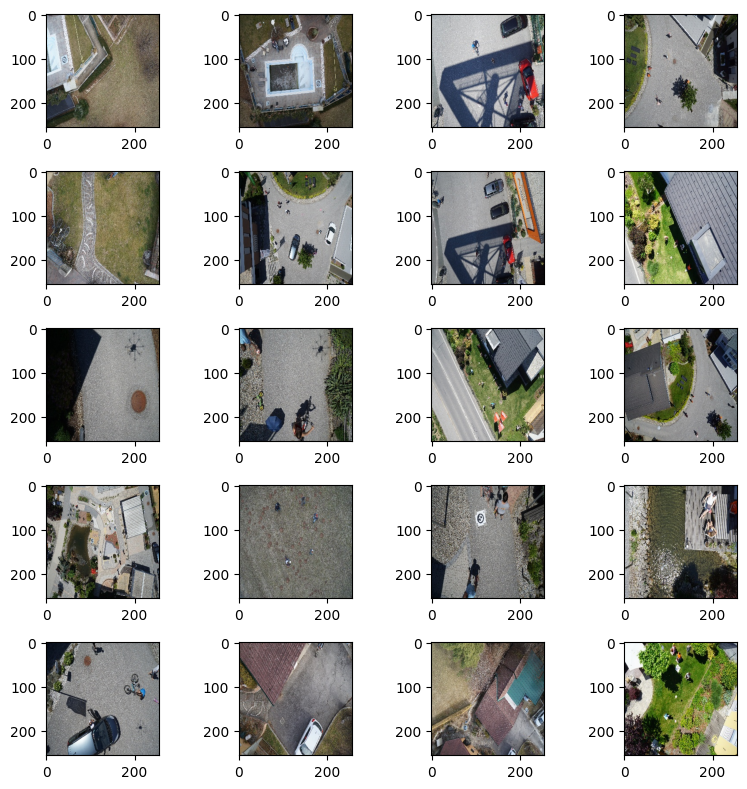

In [ ]:
visualize_images(RESIZED_DATA_ORIGINAL)

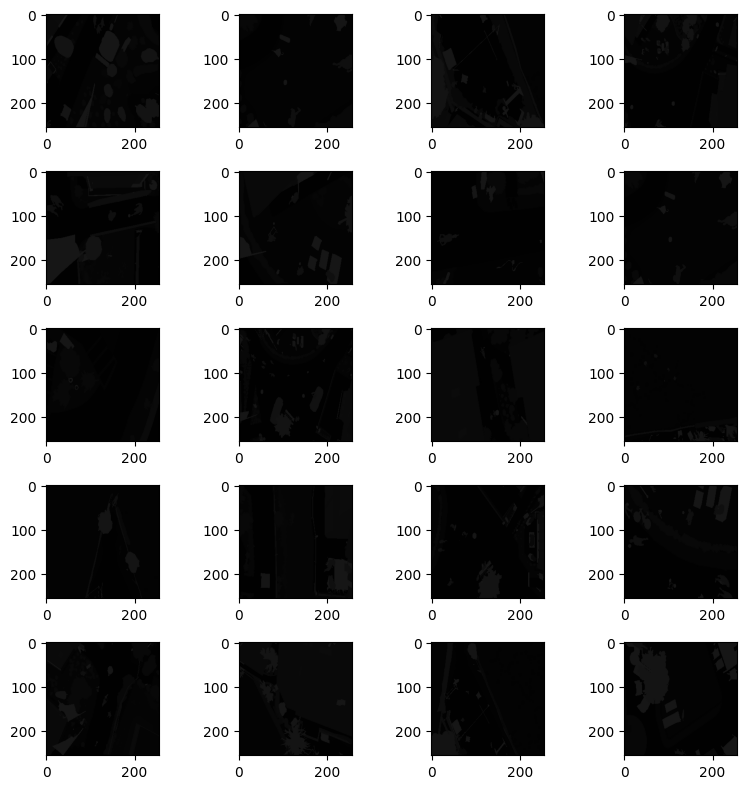

In [ ]:
visualize_images(RESIZED_DATA_MASK)

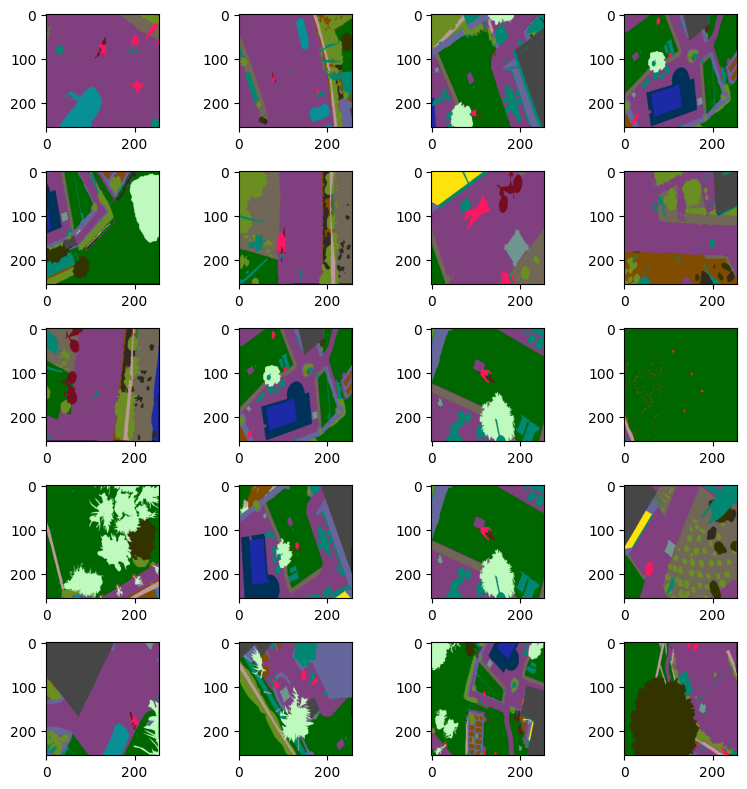

In [ ]:
visualize_images(RESIZED_DATA_RGB_MASK)

To address the limited size of the dataset, I  employed a range of **data augmentation techniques**
to artificially increase the number of training samples:

- **Rotation**
- **Flipping**
- **Blur**
- **Gaussian noise**
- **Random cutout**
- **Change HSV**


In [ ]:
augment_data(RESIZED_DATA_ORIGINAL,RESIZED_DATA_MASK,DATA_AUGMENTED,DATA_MASK_AUGMENTED)

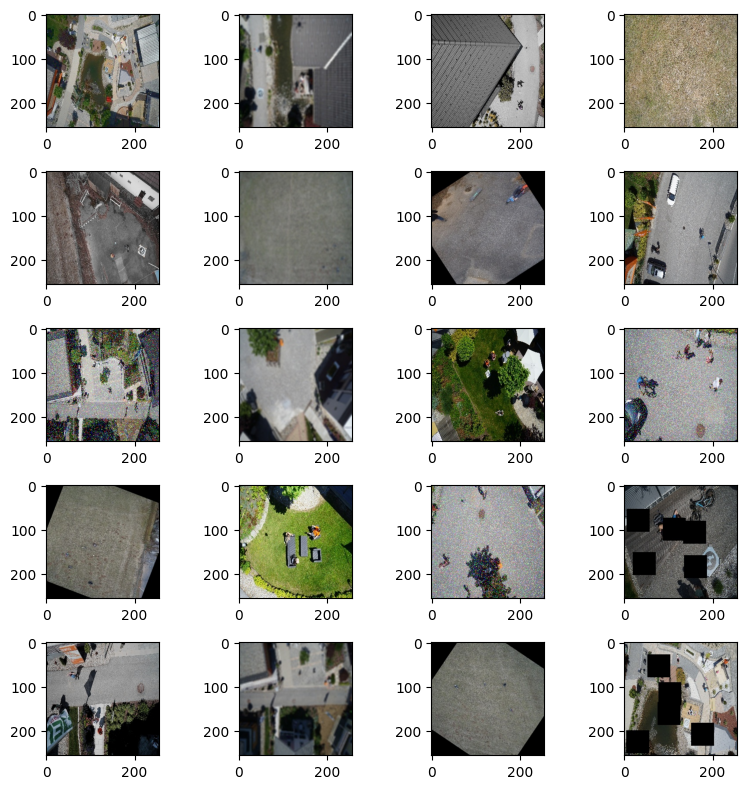

In [ ]:
visualize_images(DATA_AUGMENTED)

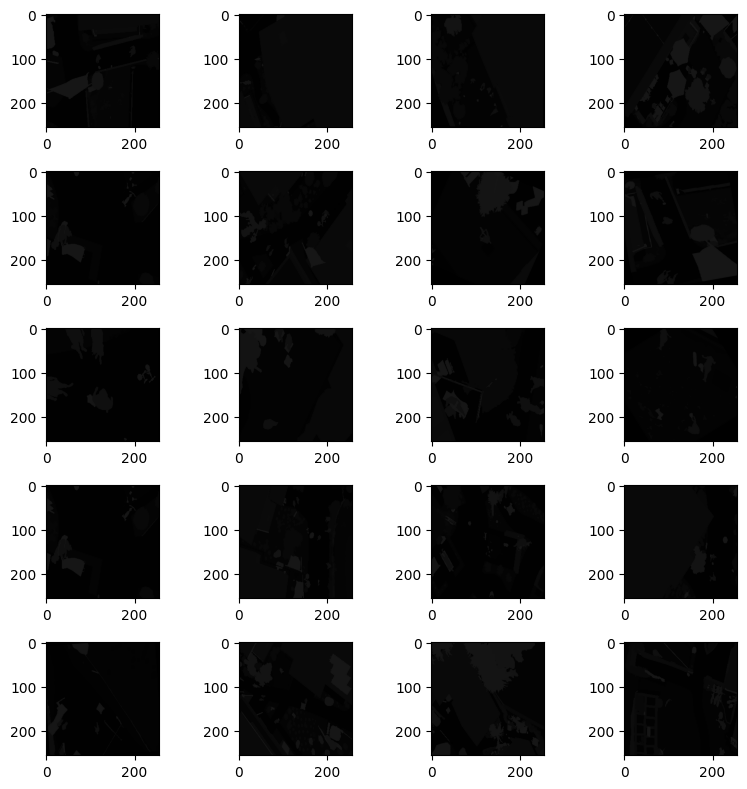

In [ ]:
visualize_images(DATA_MASK_AUGMENTED)

 I found the amount of training data still insufficient for deep learning, especially in the case the networks have a big depht like in the case of segmentation models. Therefore, I additionally applied **random cropping** on resized 1024 × 1024 images.

In [ ]:
crop_images(DATA_ORIGINAL,DATA_MASK,CROPPED_DATA_ORIGINAL,CROPPED_DATA_MASK,256)

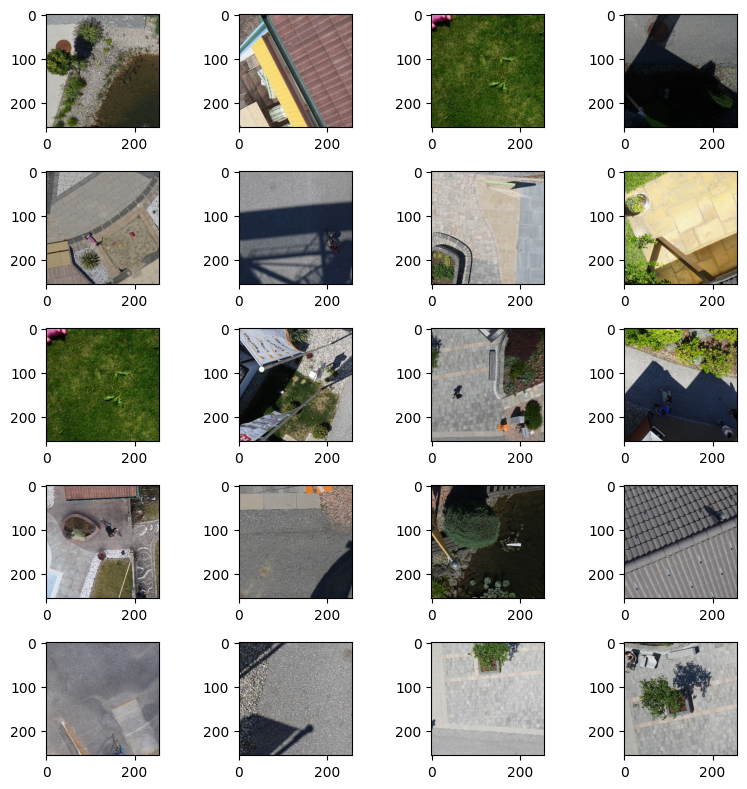

In [ ]:
visualize_images(CROPPED_DATA_ORIGINAL)

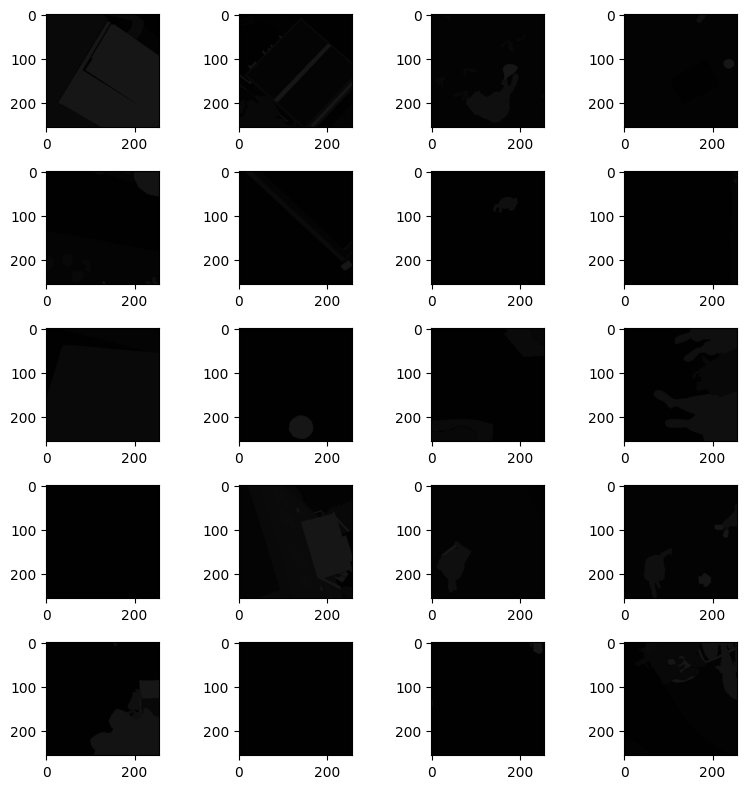

In [ ]:
visualize_images(CROPPED_DATA_MASK)

I count the total number of labels to check if the dataset is unbalanced or not

In [ ]:
labels_count = count_labels(RESIZED_DATA_MASK)

for label, count in count_labels(CROPPED_DATA_MASK).items():
    labels_count[label] = labels_count.get(label, 0) + count

for label, count in count_labels(DATA_MASK_AUGMENTED).items():
    labels_count[label] = labels_count.get(label, 0) + count

print(labels_count)

{np.uint8(1): np.int64(30510883), np.uint8(2): np.int64(2480849), np.uint8(3): np.int64(15647894), np.uint8(4): np.int64(5599317), np.uint8(5): np.int64(1818654), np.uint8(6): np.int64(593599), np.uint8(7): np.int64(562611), np.uint8(8): np.int64(5448523), np.uint8(9): np.int64(5422313), np.uint8(10): np.int64(1840677), np.uint8(11): np.int64(374945), np.uint8(12): np.int64(33043), np.uint8(13): np.int64(730182), np.uint8(14): np.int64(44883), np.uint8(15): np.int64(796284), np.uint8(16): np.int64(19090), np.uint8(17): np.int64(622894), np.uint8(18): np.int64(203770), np.uint8(19): np.int64(1671168), np.uint8(20): np.int64(947678), np.uint8(21): np.int64(177289), np.uint8(22): np.int64(2579753), np.uint8(0): np.int64(516901)}


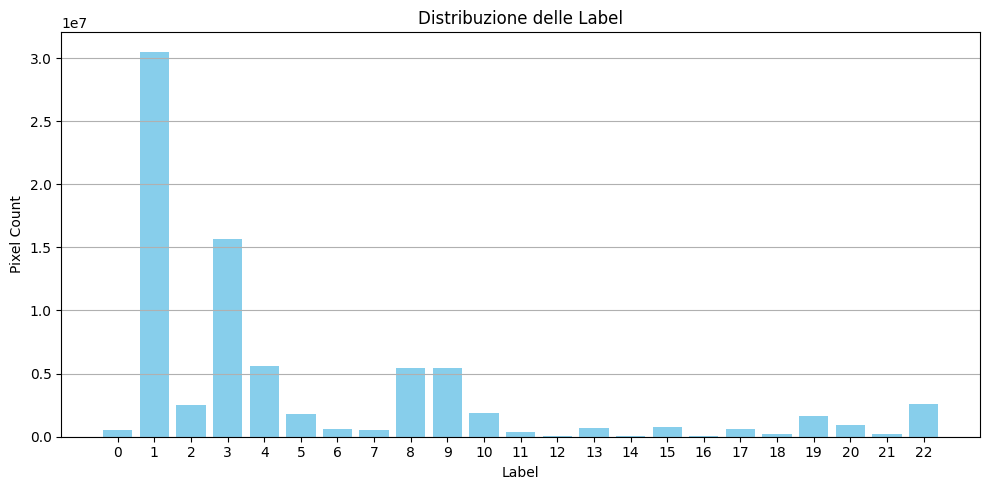

In [ ]:
# Plot
labels = list(labels_count.keys())
values = list(labels_count.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Label")
plt.ylabel("Pixel Count")
plt.title("Distribuzione delle Label")
plt.grid(True, axis='y')
plt.xticks(labels)
plt.tight_layout()
plt.show()

I add a label column that maps the triple rgb to a label. In this way I know to which object the label corresponds to.

In [ ]:
df_label=match_rgb2label(RESIZED_DATA_RGB_MASK,RESIZED_DATA_MASK,DATA_CLASS)

Processing 002.png...
Matched RGB [107 142  35] --> Label 8
Matched RGB [130  76   0] --> Label 2
Matched RGB [102 102 156] --> Label 10
Matched RGB [112 103  87] --> Label 4
Matched RGB [128  64 128] --> Label 1
Matched RGB [  0 102   0] --> Label 3
Matched RGB [51 51  0] --> Label 19
Matched RGB [  2 135 115] --> Label 22
Matched RGB [255  22  96] --> Label 15
Matched RGB [254 228  12] --> Label 11
Matched RGB [0 0 0] --> Label 0
Processing 001.png...
Matched RGB [190 153 153] --> Label 13
Matched RGB [112 150 146] --> Label 21
Matched RGB [153 153 153] --> Label 14
Matched RGB [70 70 70] --> Label 9
Matched RGB [190 250 190] --> Label 20
Matched RGB [254 148  12] --> Label 12
Processing 004.png...
Matched RGB [119  11  32] --> Label 18
Matched RGB [48 41 30] --> Label 6
Matched RGB [  9 143 150] --> Label 17
Processing 000.png...
Processing 003.png...
Processing 005.png...
Processing 006.png...
Matched RGB [ 28  42 168] --> Label 5
Processing 008.png...
Matched RGB [102  51   0] -->

In [ ]:
df_label.iloc[-1, df_label.columns.get_loc('label')] = 23
df_label

name    r    g    b  label
0     unlabeled    0    0    0    0.0
1    paved-area  128   64  128    1.0
2          dirt  130   76    0    2.0
3         grass    0  102    0    3.0
4        gravel  112  103   87    4.0
5         water   28   42  168    5.0
6         rocks   48   41   30    6.0
7          pool    0   50   89    7.0
8    vegetation  107  142   35    8.0
9          roof   70   70   70    9.0
10         wall  102  102  156   10.0
11       window  254  228   12   11.0
12         door  254  148   12   12.0
13        fence  190  153  153   13.0
14   fence-pole  153  153  153   14.0
15       person  255   22   96   15.0
16          dog  102   51    0   16.0
17          car    9  143  150   17.0
18      bicycle  119   11   32   18.0
19         tree   51   51    0   19.0
20    bald-tree  190  250  190   20.0
21    ar-marker  112  150  146   21.0
22     obstacle    2  135  115   22.0
23  conflicting  255    0    0   23.0

### Creation train val test set

I divide the data in train test and validation set

In [ ]:
image_path=[os.path.join(RESIZED_DATA_ORIGINAL,img) for img in sorted(os.listdir(RESIZED_DATA_ORIGINAL))]
mask_path=[os.path.join(RESIZED_DATA_MASK,img) for img in sorted(os.listdir(RESIZED_DATA_MASK))]

# train+val e test
X_temp, X_test, y_temp, y_test = train_test_split(
    image_path, mask_path, test_size=0.20, random_state=42
)

training_image_aug=[os.path.join(DATA_AUGMENTED,img) for img in sorted(os.listdir(DATA_AUGMENTED))]
training_mask_aug=[os.path.join(DATA_MASK_AUGMENTED,img) for img in sorted(os.listdir(DATA_MASK_AUGMENTED))]
training_image_aug+=X_temp
training_mask_aug+=y_temp

training_image=[os.path.join(CROPPED_DATA_ORIGINAL,img) for img in sorted(os.listdir(CROPPED_DATA_ORIGINAL))]
training_mask=[os.path.join(CROPPED_DATA_MASK,img) for img in sorted(os.listdir(CROPPED_DATA_MASK))]
training_image+=training_image_aug
training_mask+=training_mask_aug


# train e val
X_train, X_val, y_train, y_val = train_test_split(
    training_image, training_mask, test_size=0.10, random_state=42)

In [ ]:
print(f"training:{len(X_train)}\nvale:{len(X_val)}\ntest:{len(X_test)}")

training:1008
vale:112
test:80


In [ ]:
train_dataset=get_dataset(1,256,X_train, y_train)
val_dataset=get_dataset(1,256,X_val, y_val)
test_dataset=get_dataset(1,256,X_test, y_test)

In [ ]:
print(train_dataset.element_spec)
print(val_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))


## Segmentation models



I develop 4 models:
- **UNET**
- **RESUNET**
- **SEGFORMER**
- **DEEPVLABV3+**

Each model section it's divided into:
1. **Building block of the model**
2. **Model definition**
3. **Compiling and training of the model**

To find the best hyperparameters I train **5 models** for each model type by using **random sweep agent** of wandb library.
The hyperparameters are defined in Constant.

Then I will take the model with the **best accuracy** score on validation

### U-Net

#### Building block

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)


    return x

In [ ]:
def downsample_block(x, n_filters,dropout):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(dropout)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters, dropout):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(dropout)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

#### U-NET model

In [ ]:
def UNet(input_shape=(256, 256, 3),num_classes=23,dropout=0.3):

    # inputs
    inputs = layers.Input(input_shape)

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64,dropout)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128,dropout)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256,dropout)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512,dropout)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512,dropout)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256,dropout)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128,dropout)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64,dropout)

    # outputs
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = UNet()

In [ ]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout_32[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    295,168 │ dropout_33[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ dropout_34[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_10[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 16, 16,    │          0 │ max_pooling2d_3[

 Total params: 34,514,775 (131.66 MB)

 Trainable params: 34,514,775 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'Unet'), count=5)

Create sweep with ID: j85z1iot
Sweep URL: https://wandb.ai/SanRaffaele/Environment-Segmentation/sweeps/j85z1iot


wandb: Agent Starting Run: 1e96ne17 with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 58s 170ms/step - accuracy: 0.4328 - loss: 2.4216 - val_accuracy: 0.5480 - val_loss: 1.6080 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5312 - loss: 1.6825 - val_accuracy: 0.5679 - val_loss: 1.5131 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.5547 - loss: 1.5846 - val_accuracy: 0.5929 - val_loss: 1.3778 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5688 - loss: 1.5043 - val_accuracy: 0.6063 - val_loss: 1.3227 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5811 - loss: 1.4491 - val_accuracy: 0.6174 - val_loss: 1.2968 - learning_rate: 0.0010
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.5901 - loss: 1.4043 - val_accuracy: 0.6356 - val_loss: 1.2524 - learning_rate: 0.0010
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.

wandb: Adding directory to artifact (/content/wandb/run-20250723_043950-1e96ne17/files/tensorboard_logs)... Done. 0.3s


wandb: Agent Starting Run: zw6oahn6 with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.3
wandb: 	epoch: 100
wandb: 	lr: 0.0001


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 376ms/step - accuracy: 0.2956 - loss: 2.5283 - val_accuracy: 0.5256 - val_loss: 1.9349 - learning_rate: 1.0000e-04
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.5084 - loss: 1.9157 - val_accuracy: 0.5538 - val_loss: 1.7362 - learning_rate: 1.0000e-04
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.5357 - loss: 1.7598 - val_accuracy: 0.5752 - val_loss: 1.5588 - learning_rate: 1.0000e-04
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.5491 - loss: 1.6649 - val_accuracy: 0.5838 - val_loss: 1.4822 - learning_rate: 1.0000e-04
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.5605 - loss: 1.5672 - val_accuracy: 0.5898 - val_loss: 1.5627 - learning_rate: 1.0000e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.5779 - loss: 1.5019 - val_accuracy: 0.5951 - val_loss: 1.6208 - learning_rate: 1.0000e-04
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 

wandb: Adding directory to artifact (/content/wandb/run-20250723_045833-zw6oahn6/files/tensorboard_logs)... Done. 0.3s


wandb: Agent Starting Run: dtk208fq with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.3
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.4575 - loss: 2.0607 - val_accuracy: 0.5286 - val_loss: 1.6356 - learning_rate: 0.0010
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.5278 - loss: 1.6649 - val_accuracy: 0.5534 - val_loss: 1.4881 - learning_rate: 0.0010
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.5541 - loss: 1.5346 - val_accuracy: 0.5718 - val_loss: 1.3975 - learning_rate: 0.0010
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5692 - loss: 1.4651 - val_accuracy: 0.5923 - val_loss: 1.3437 - learning_rate: 0.0010
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5830 - loss: 1.4211 - val_accuracy: 0.6039 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 6/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.5922 - loss: 1.3878 - val_accuracy: 0.6119 - val_loss: 1.2813 - learning_rate: 0.0010
Epoch 7/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step -

wandb: Adding directory to artifact (/content/wandb/run-20250723_051413-dtk208fq/files/tensorboard_logs)... Done. 0.3s


wandb: Agent Starting Run: ivs6b03f with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.4016 - loss: 2.4174 - val_accuracy: 0.5141 - val_loss: 1.7239 - learning_rate: 0.0010
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.5248 - loss: 1.7151 - val_accuracy: 0.5445 - val_loss: 1.6233 - learning_rate: 0.0010
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.5479 - loss: 1.5951 - val_accuracy: 0.5804 - val_loss: 1.4378 - learning_rate: 0.0010
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.5640 - loss: 1.5083 - val_accuracy: 0.5969 - val_loss: 1.3611 - learning_rate: 0.0010
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.5740 - loss: 1.4651 - val_accuracy: 0.6173 - val_loss: 1.3365 - learning_rate: 0.0010
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.5844 - loss: 1.4181 - val_accuracy: 0.6265 - val_loss: 1.2830 - learning_rate: 0.0010
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accura

wandb: Adding directory to artifact (/content/wandb/run-20250723_055043-ivs6b03f/files/tensorboard_logs)... Done. 0.3s


wandb: Agent Starting Run: p0s0w5wg with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.4
wandb: 	epoch: 100
wandb: 	lr: 0.0001


Epoch 1/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.4298 - loss: 2.1762 - val_accuracy: 0.5495 - val_loss: 1.6294 - learning_rate: 1.0000e-04
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5386 - loss: 1.6629 - val_accuracy: 0.5780 - val_loss: 1.4856 - learning_rate: 1.0000e-04
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5619 - loss: 1.5325 - val_accuracy: 0.5799 - val_loss: 1.4509 - learning_rate: 1.0000e-04
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5720 - loss: 1.4767 - val_accuracy: 0.5908 - val_loss: 1.4108 - learning_rate: 1.0000e-04
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5863 - loss: 1.4241 - val_accuracy: 0.6038 - val_loss: 1.3738 - learning_rate: 1.0000e-04
Epoch 6/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.5959 - loss: 1.3835 - val_accuracy: 0.6162 - val_loss: 1.3281 - learning_rate: 1.0000e-04
Epoch 7/100
1008/1008 ━━━━━━━━━━━━

wandb: Adding directory to artifact (/content/wandb/run-20250723_060723-p0s0w5wg/files/tensorboard_logs)... Done. 0.3s


### ResU-Net

#### Building block

In [ ]:
def residual_block(x, n_filters, next_block_res=True):
    shortcut = x
    x = layers.GroupNormalization(groups=x.shape[-1])(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)


    x = layers.GroupNormalization(groups=x.shape[-1])(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)


    # Adapt the shortcut if it is necessary by changing the number of channer by using Conv with 1x1 kernel size
    if shortcut.shape[-1] != n_filters:
        shortcut = layers.Conv2D(n_filters, 1, padding="same")(shortcut)

    x = layers.Add()([x, shortcut])

    if(next_block_res == False):
      x = layers.ReLU()(x)

    return x

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)


    return x

In [ ]:
def downsample_block(x, n_filters,dropout, next_block_res=True):
    f = residual_block(x, n_filters,next_block_res)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(dropout)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters,dropout):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(dropout)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

#### ResU-Net model

In [ ]:
def ResUnet(input_shape=(256, 256, 3),num_classes=23,dropout=0.3):

    # inputs
    inputs = layers.Input(input_shape)
    f0 = layers.Conv2D(64, 7, padding = "same", activation = "relu",strides=1,kernel_initializer = "he_normal")(inputs)
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(f0, 64,dropout)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128,dropout)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256,dropout)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512,dropout,next_block_res=False)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512,dropout)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256,dropout)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128,dropout)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64,dropout)

    # outputs
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    resunet_model = tf.keras.Model(inputs, outputs, name="ResU-Net")

    return resunet_model

In [ ]:
resunet_model = ResUnet()

In [ ]:
resunet_model.summary()

Model: "ResU-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 256, 256,  │        128 │ conv2d_23[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_24[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 256, 256,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 256, 256,  │          0 │ conv2d_25[0][0],  │
│                     │ 64)               │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ add_32[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 128, 128,  │        128 │ dropout_40[0][0]  │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │     73,856 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_26[0][0]   │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ group_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │    147,584 │ re_lu_3[0][0]   

 Total params: 34,735,255 (132.50 MB)

 Trainable params: 34,735,255 (132.50 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'ResUnet'), count=5)

Create sweep with ID: 33xuq1lb
Sweep URL: https://wandb.ai/SanRaffaele/Environment-Segmentation/sweeps/33xuq1lb


wandb: Agent Starting Run: y61qy6px with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.3
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.4527 - loss: 2.0012 - val_accuracy: 0.5115 - val_loss: 1.6193 - learning_rate: 0.0010
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5232 - loss: 1.6535 - val_accuracy: 0.5465 - val_loss: 1.4642 - learning_rate: 0.0010
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5492 - loss: 1.5388 - val_accuracy: 0.5625 - val_loss: 1.4343 - learning_rate: 0.0010
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5660 - loss: 1.4782 - val_accuracy: 0.5679 - val_loss: 1.4271 - learning_rate: 0.0010
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5790 - loss: 1.4405 - val_accuracy: 0.5808 - val_loss: 1.4206 - learning_rate: 0.0010
Epoch 6/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5902 - loss: 1.3980 - val_accuracy: 0.5824 - val_loss: 1.4335 - learning_rate: 0.0010
Epoch 7/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step -

wandb: Adding directory to artifact (/content/wandb/run-20250723_064126-y61qy6px/files/tensorboard_logs)... Done. 0.5s


wandb: Agent Starting Run: 9is1qgpb with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.3
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 340ms/step - accuracy: 0.4148 - loss: 2.1730 - val_accuracy: 0.5269 - val_loss: 1.6061 - learning_rate: 0.0010
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.5338 - loss: 1.6196 - val_accuracy: 0.5795 - val_loss: 1.4362 - learning_rate: 0.0010
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.5691 - loss: 1.4893 - val_accuracy: 0.5955 - val_loss: 1.3629 - learning_rate: 0.0010
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.5894 - loss: 1.4206 - val_accuracy: 0.6336 - val_loss: 1.2459 - learning_rate: 0.0010
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.6052 - loss: 1.3594 - val_accuracy: 0.6296 - val_loss: 1.2400 - learning_rate: 0.0010
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.6042 - loss: 1.5301 - val_accuracy: 0.6102 - val_loss: 1.3688 - learning_rate: 0.0010
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accurac

wandb: Adding directory to artifact (/content/wandb/run-20250723_072143-9is1qgpb/files/tensorboard_logs)... Done. 0.3s


wandb: Agent Starting Run: bvaxii99 with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.4
wandb: 	epoch: 100
wandb: 	lr: 0.0001


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - accuracy: 0.3267 - loss: 2.5095 - val_accuracy: 0.4649 - val_loss: 1.8442 - learning_rate: 1.0000e-04
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.4641 - loss: 1.8820 - val_accuracy: 0.5001 - val_loss: 1.7089 - learning_rate: 1.0000e-04
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.5087 - loss: 1.7261 - val_accuracy: 0.5472 - val_loss: 1.5543 - learning_rate: 1.0000e-04
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.5349 - loss: 1.6222 - val_accuracy: 0.5785 - val_loss: 1.4492 - learning_rate: 1.0000e-04
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.5555 - loss: 1.5456 - val_accuracy: 0.5899 - val_loss: 1.3865 - learning_rate: 1.0000e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.5728 - loss: 1.4853 - val_accuracy: 0.5876 - val_loss: 1.3700 - learning_rate: 1.0000e-04
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━

wandb: Adding directory to artifact (/content/wandb/run-20250723_074150-bvaxii99/files/tensorboard_logs)... Done. 0.3s


wandb: Agent Starting Run: cg6ud3zp with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.0001


Epoch 1/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.4242 - loss: 2.0834 - val_accuracy: 0.5200 - val_loss: 1.5996 - learning_rate: 1.0000e-04
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5245 - loss: 1.6366 - val_accuracy: 0.5773 - val_loss: 1.4134 - learning_rate: 1.0000e-04
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5660 - loss: 1.4945 - val_accuracy: 0.6043 - val_loss: 1.3265 - learning_rate: 1.0000e-04
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5942 - loss: 1.4079 - val_accuracy: 0.6191 - val_loss: 1.2846 - learning_rate: 1.0000e-04
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.6132 - loss: 1.3465 - val_accuracy: 0.6346 - val_loss: 1.2588 - learning_rate: 1.0000e-04
Epoch 6/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6276 - loss: 1.2979 - val_accuracy: 0.6445 - val_loss: 1.2359 - learning_rate: 1.0000e-04
Epoch 7/100
1008/1008 ━━━━━━━━━━━━

wandb: Adding directory to artifact (/content/wandb/run-20250723_075951-cg6ud3zp/files/tensorboard_logs)... Done. 0.3s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6wrk0tla with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.4318 - loss: 2.0963 - val_accuracy: 0.5443 - val_loss: 1.5607 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.5304 - loss: 1.6256 - val_accuracy: 0.5963 - val_loss: 1.4171 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.5663 - loss: 1.4998 - val_accuracy: 0.6223 - val_loss: 1.3212 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5839 - loss: 1.4255 - val_accuracy: 0.6261 - val_loss: 1.2894 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5979 - loss: 1.3768 - val_accuracy: 0.6361 - val_loss: 1.2608 - learning_rate: 0.0010
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.6095 - loss: 1.3271 - val_accuracy: 0.6432 - val_loss: 1.2230 - learning_rate: 0.0010
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.

wandb: Adding directory to artifact (/content/wandb/run-20250723_083752-6wrk0tla/files/tensorboard_logs)... Done. 0.3s


### SegFormer

#### Building blocks

In [ ]:
def mix_ffn(x, dropout):
    W = int(x.shape[1] ** 0.5)
    dim=x.shape[-1]
    x = layers.Dense(dim*2)(x)
    x = layers.Reshape((W, W, dim*2))(x)
    x = layers.DepthwiseConv2D(kernel_size=3, padding='same')(x)
    x = layers.Activation("gelu")(x)
    x = layers.Reshape((-1, dim*2))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dim)(x)
    return x#[4096 x 32]

In [ ]:
def transformer(encoded_patches,num_heads, projection_dim,dropout):
    # Layer normalization 1.
    x1 = layers.LayerNormalization()(encoded_patches)#[4096 x 32]

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=dropout
    )(x1, x1)#es[4096 x32]

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization()(x2)

    # MLP layer 1.
    x4 = mix_ffn(x3, dropout)

    # Skip connection 2.
    encoded_patches = layers.Add()([x4, x2])# dim finale[num patcheds, projected_dim][4096,32]
    return encoded_patches

In [ ]:
def hierarchical_vit_encoder(img, transformer_layers=4,dropout=0.2):
    features = []
    patches = img
    embed_dims = [32, 64, 128, 256]
    kernel_sizes = [7, 3, 3, 3]
    strides = [4, 2, 2, 2]

    for i in range(len((embed_dims))):
        patches = layers.Conv2D(embed_dims[i], kernel_size=kernel_sizes[i], strides=strides[i], padding="same",kernel_initializer = "he_normal")(patches)
        h, w = ops.shape(patches)[1], ops.shape(patches)[2] #1) [1 x 64 x 64 x 32]
        x = layers.Reshape((-1, embed_dims[i]))(patches) #[4096 x 32]
        for _ in range(transformer_layers):
            x = transformer(x, num_heads=8, projection_dim=embed_dims[i],dropout=dropout)
        x_out = layers.Reshape((h, w, embed_dims[i]))(x)#[1 x 64 x 64 x 32]
        features.append(x_out)
    return features

In [ ]:
def segformer_decoder(features, num_classes):

    projected = []
    target_size = (64, 64)  # Risoluzione più alta (es. F1)

    for i in range(4):
        h_i, w_i =  ops.shape(features[i])[1],  ops.shape(features[i])[2]
        x = layers.Reshape((-1, features[i].shape[-1]))(features[i])    # (B, H_i*W_i, C_i)
        x = layers.Dense(256)(x)                                        # Proiezione MLP (Linear)
        x = layers.Reshape((h_i, w_i, 256))(x)

        x = layers.UpSampling2D(
            size=(target_size[0] // h_i, target_size[1] // w_i),
            interpolation="bilinear"
        )(x)

        projected.append(x)

    # Concateniamo lungo i canali → shape: (B, H, W, 4*256)
    x = layers.Concatenate(axis=-1)(projected)

    # MLP finale: Dense applicato punto per punto (equivalente a Linear 1x1)
    x = layers.Reshape((-1, 4 * 256))(x)                # (B, H*W, 1024)
    x = layers.Dense(256, activation='gelu')(x)         # (B, H*W, 256)
    x = layers.Dense(num_classes)(x)                    # (B, H*W, Ncls)
    x = layers.Reshape((target_size[0], target_size[1], num_classes))(x)  # (B, H, W, Ncls)
    x = layers.Softmax()(x)

    # Upsample alla dimensione finale
    x = layers.UpSampling2D(size=4, interpolation='bilinear')(x)

    return x

#### Segformer model

In [ ]:
def Segformer(input_shape=(256, 256, 3), num_classes=23 ,dropout=0.2):
    img = layers.Input(shape=input_shape)
    encoder_outputs = hierarchical_vit_encoder(img,dropout=dropout)
    decoder_output = segformer_decoder(encoder_outputs, num_classes)
    segformer = tf.keras.Model(inputs=img, outputs=decoder_output, name="SegFormer")

    return segformer


In [ ]:
model_seg_former = Segformer(input_shape=(256, 256, 3), num_classes=23)
model_seg_former.summary()

Model: "SegFormer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4096, 32)  │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1024, 64)  │          0 │ conv2d_1[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_20          │ (None, 256, 128)  │          0 │ conv2d_2[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_30          │ (None, 64, 256)   │          0 │ conv2d_3[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4096, 32)  │         64 │ reshape[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 64)  │        128 │ reshape_10[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 128)  │        256 │ reshape_20[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ reshape_30[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4096, 32)  │     33,568 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1024, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 256)   │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,418,071 (51.19 MB)

 Trainable params: 13,418,071 (51.19 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'Segformer'), count=5)

Create sweep with ID: 8eyom63w
Sweep URL: https://wandb.ai/SanRaffaele/Environment-Segmentation/sweeps/8eyom63w


wandb: Agent Starting Run: ds80h5io with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.3756 - loss: 2.9295 - val_accuracy: 0.5833 - val_loss: 1.5417 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - accuracy: 0.5206 - loss: 1.7735 - val_accuracy: 0.5615 - val_loss: 1.5327 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.5198 - loss: 1.7293 - val_accuracy: 0.5584 - val_loss: 1.5175 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 64s 318ms/step - accuracy: 0.5398 - loss: 1.6458 - val_accuracy: 0.5707 - val_loss: 1.4451 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 227ms/step - accuracy: 0.5406 - loss: 1.6366 - val_accuracy: 0.5595 - val_loss: 1.4940 - learning_rate: 0.0010
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.5605 - loss: 1.5502 - val_accuracy: 0.6085 - val_loss: 1.3575 - learning_rate: 0.0010
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 227ms/step - accuracy

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


202/202 ━━━━━━━━━━━━━━━━━━━━ 57s 282ms/step - accuracy: 0.6349 - loss: 1.2277 - val_accuracy: 0.6625 - val_loss: 1.1239 - learning_rate: 1.0000e-04
Epoch 29/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.6362 - loss: 1.2219 - val_accuracy: 0.6656 - val_loss: 1.1008 - learning_rate: 1.0000e-04
Epoch 30/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - accuracy: 0.6451 - loss: 1.1871 - val_accuracy: 0.6739 - val_loss: 1.0839 - learning_rate: 1.0000e-04
Epoch 31/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.6487 - loss: 1.1765 - val_accuracy: 0.6784 - val_loss: 1.0716 - learning_rate: 1.0000e-04
Epoch 32/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 227ms/step - accuracy: 0.6552 - loss: 1.1543 - val_accuracy: 0.6677 - val_loss: 1.0879 - learning_rate: 1.0000e-04
Epoch 33/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - accuracy: 0.6581 - loss: 1.1451 - val_accuracy: 0.6778 - val_loss: 1.0642 - learning_rate: 1.0000e-04
Epoch 34/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 2

wandb: Adding directory to artifact (/content/wandb/run-20250722_205153-ds80h5io/files/tensorboard_logs)... Done. 0.4s


wandb: Agent Starting Run: scbyvv0z with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 220s 82ms/step - accuracy: 0.3567 - loss: 3.0717 - val_accuracy: 0.3800 - val_loss: 2.0485 - learning_rate: 0.0010
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.4027 - loss: 2.1178 - val_accuracy: 0.3785 - val_loss: 2.0613 - learning_rate: 0.0010
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.4046 - loss: 2.7421 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.4010 - loss: 9.6543 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - accuracy: 0.4010 - loss: 9.6543 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 6/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4010 - loss: 9.6541
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step

wandb: Adding directory to artifact (/content/wandb/run-20250722_221819-scbyvv0z/files/tensorboard_logs)... Done. 0.4s


wandb: Agent Starting Run: omcl1ads with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.4
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.3219 - loss: 3.3430 - val_accuracy: 0.4688 - val_loss: 1.8965 - learning_rate: 0.0010
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 463ms/step - accuracy: 0.4990 - loss: 1.8679 - val_accuracy: 0.5873 - val_loss: 1.4527 - learning_rate: 0.0010
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 463ms/step - accuracy: 0.5268 - loss: 1.6636 - val_accuracy: 0.5928 - val_loss: 1.3954 - learning_rate: 0.0010
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 447ms/step - accuracy: 0.5526 - loss: 1.5657 - val_accuracy: 0.5318 - val_loss: 1.6039 - learning_rate: 0.0010
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 447ms/step - accuracy: 0.5638 - loss: 1.5242 - val_accuracy: 0.5275 - val_loss: 1.5073 - learning_rate: 0.0010
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 464ms/step - accuracy: 0.5789 - loss: 1.4467 - val_accuracy: 0.6109 - val_loss: 1.3082 - learning_rate: 0.0010
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 463ms/step - accuracy

wandb: Adding directory to artifact (/content/wandb/run-20250723_000735-omcl1ads/files/tensorboard_logs)... Done. 0.4s


wandb: Agent Starting Run: crheqqid with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.3
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 185s 77ms/step - accuracy: 0.3465 - loss: 9.7406 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 65s 64ms/step - accuracy: 0.4010 - loss: 9.6543 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 65s 64ms/step - accuracy: 0.4010 - loss: 9.6543 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.4010 - loss: 9.6543 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 65s 64ms/step - accuracy: 0.4010 - loss: 9.6543 - val_accuracy: 0.3785 - val_loss: 10.0169 - learning_rate: 0.0010
Epoch 6/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4010 - loss: 9.6541
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 65s 64ms/st

wandb: Adding directory to artifact (/content/wandb/run-20250723_012811-crheqqid/files/tensorboard_logs)... Done. 0.4s


wandb: Agent Starting Run: s56p7qt2 with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.4
wandb: 	epoch: 100
wandb: 	lr: 0.001


Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 233s 636ms/step - accuracy: 0.3829 - loss: 2.6961 - val_accuracy: 0.4512 - val_loss: 1.8499 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - accuracy: 0.5029 - loss: 1.8325 - val_accuracy: 0.5616 - val_loss: 1.4930 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - accuracy: 0.5380 - loss: 1.6691 - val_accuracy: 0.5406 - val_loss: 1.6817 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 237ms/step - accuracy: 0.5167 - loss: 1.7993 - val_accuracy: 0.5715 - val_loss: 1.4768 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 237ms/step - accuracy: 0.5496 - loss: 1.5959 - val_accuracy: 0.5850 - val_loss: 1.4226 - learning_rate: 0.0010
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 237ms/step - accuracy: 0.5575 - loss: 1.5483 - val_accuracy: 0.6126 - val_loss: 1.2909 - learning_rate: 0.0010
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 229ms/step - accur

wandb: Adding directory to artifact (/content/wandb/run-20250723_031836-s56p7qt2/files/tensorboard_logs)... Done. 0.4s


### DeepLab v3 plus

#### Building blocks

In [ ]:
def convolution_block(block_input,num_filters=256,kernel_size=3,dilation_rate=1):
    x = layers.Conv2D(num_filters,kernel_size=kernel_size,dilation_rate=dilation_rate,padding="same",kernel_initializer = "he_normal")(block_input)
    x = layers.GroupNormalization(groups=x.shape[-1])(x)
    x = layers.ReLU()(x)
    return x


In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

#### DeeplabV3Plus model

In [ ]:
def DeeplabV3Plus(image_size=256, num_classes=23):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_tensor=preprocessed
    )

    x = resnet50.get_layer("conv4_block6_2_relu").output
    print(x.shape)
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same",activation="softmax")(x)
    deeplabv3 = tf.keras.Model(inputs=model_input, outputs=model_output, name="SegFormer")

    return deeplabv3




In [ ]:
model_deepLab = DeeplabV3Plus(image_size=256, num_classes=23)
model_deepLab.summary()


(None, 16, 16, 256)


Model: "SegFormer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 256, 256,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 256, 256,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ add_37[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,855,655 (45.23 MB)

 Trainable params: 11,827,111 (45.12 MB)

 Non-trainable params: 28,544 (111.50 KB)

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'DeepLabV3Plus'), count=5)

Create sweep with ID: hqp4a8ht
Sweep URL: https://wandb.ai/SanRaffaele/Environment-Segmentation/sweeps/hqp4a8ht


wandb: Agent Starting Run: 0ol05z3v with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.001


(None, 16, 16, 256)
Epoch 1/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 93s 36ms/step - accuracy: 0.4211 - loss: 2.0799 - val_accuracy: 0.3615 - val_loss: 2.0442 - learning_rate: 0.0010
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.4934 - loss: 1.7441 - val_accuracy: 0.3684 - val_loss: 2.1525 - learning_rate: 0.0010
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5297 - loss: 1.6174 - val_accuracy: 0.3618 - val_loss: 2.2139 - learning_rate: 0.0010
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5509 - loss: 1.5404 - val_accuracy: 0.3675 - val_loss: 2.0812 - learning_rate: 0.0010
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5689 - loss: 1.4749 - val_accuracy: 0.3730 - val_loss: 2.2508 - learning_rate: 0.0010
Epoch 6/100
1007/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5860 - loss: 1.4172
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1008/1008 ━━━━━━━━━━━━━━━━━━

wandb: Adding directory to artifact (/content/wandb/run-20250723_092237-0ol05z3v/files/tensorboard_logs)... Done. 0.7s


wandb: Agent Starting Run: s0bw5h38 with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.0001


(None, 16, 16, 256)
Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 106s 512ms/step - accuracy: 0.2850 - loss: 2.8208 - val_accuracy: 0.2668 - val_loss: 2.8323 - learning_rate: 1.0000e-04
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.5491 - loss: 1.7137 - val_accuracy: 0.2848 - val_loss: 2.6473 - learning_rate: 1.0000e-04
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.6325 - loss: 1.4048 - val_accuracy: 0.2685 - val_loss: 2.4631 - learning_rate: 1.0000e-04
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6975 - loss: 1.1734 - val_accuracy: 0.2587 - val_loss: 2.5438 - learning_rate: 1.0000e-04
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.7412 - loss: 1.0041 - val_accuracy: 0.2735 - val_loss: 2.4666 - learning_rate: 1.0000e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7702 - loss: 0.8872 - val_accuracy: 0.2407 - val_loss: 2.8287 - learning_rate: 1.0000e-04
Epoch 7/100
101/101

wandb: Adding directory to artifact (/content/wandb/run-20250723_100602-s0bw5h38/files/tensorboard_logs)... Done. 0.6s


wandb: Agent Starting Run: i7jn0zm3 with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.3
wandb: 	epoch: 100
wandb: 	lr: 0.0001


(None, 16, 16, 256)
Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 104s 243ms/step - accuracy: 0.3505 - loss: 2.5052 - val_accuracy: 0.2841 - val_loss: 2.4390 - learning_rate: 1.0000e-04
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.5785 - loss: 1.5729 - val_accuracy: 0.2930 - val_loss: 2.3638 - learning_rate: 1.0000e-04
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6546 - loss: 1.2919 - val_accuracy: 0.3097 - val_loss: 2.4154 - learning_rate: 1.0000e-04
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7173 - loss: 1.0669 - val_accuracy: 0.3234 - val_loss: 2.4577 - learning_rate: 1.0000e-04
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.7661 - loss: 0.8936 - val_accuracy: 0.2846 - val_loss: 2.5817 - learning_rate: 1.0000e-04
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.7925 - loss: 0.7903 - val_accuracy: 0.2784 - val_loss: 2.7485 - learning_rate: 1.0000e-04
Epoch 7/100
201/202 ━━━━

wandb: Adding directory to artifact (/content/wandb/run-20250723_102652-i7jn0zm3/files/tensorboard_logs)... Done. 0.6s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l533h9vl with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.4
wandb: 	epoch: 100
wandb: 	lr: 0.001


(None, 16, 16, 256)
Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 98s 230ms/step - accuracy: 0.4193 - loss: 2.1410 - val_accuracy: 0.3365 - val_loss: 2.1745 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.5318 - loss: 1.6605 - val_accuracy: 0.3736 - val_loss: 2.2223 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5615 - loss: 1.5500 - val_accuracy: 0.2410 - val_loss: 2.3086 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.5933 - loss: 1.4396 - val_accuracy: 0.3286 - val_loss: 2.1852 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6152 - loss: 1.3511 - val_accuracy: 0.3538 - val_loss: 2.2041 - learning_rate: 0.0010
Epoch 6/100
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6439 - loss: 1.2514
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/s

wandb: Adding directory to artifact (/content/wandb/run-20250723_104943-l533h9vl/files/tensorboard_logs)... Done. 0.7s


wandb: Agent Starting Run: v8553nde with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.4
wandb: 	epoch: 100
wandb: 	lr: 0.001


(None, 16, 16, 256)
Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 98s 477ms/step - accuracy: 0.3964 - loss: 2.3101 - val_accuracy: 0.2990 - val_loss: 2.1472 - learning_rate: 0.0010
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.5648 - loss: 1.5814 - val_accuracy: 0.2874 - val_loss: 2.1905 - learning_rate: 0.0010
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.6082 - loss: 1.4007 - val_accuracy: 0.3593 - val_loss: 2.1406 - learning_rate: 0.0010
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.6437 - loss: 1.2755 - val_accuracy: 0.3675 - val_loss: 2.0800 - learning_rate: 0.0010
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6734 - loss: 1.1605 - val_accuracy: 0.3290 - val_loss: 2.3944 - learning_rate: 0.0010
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7027 - loss: 1.0487 - val_accuracy: 0.3452 - val_loss: 2.4971 - learning_rate: 0.0010
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s

wandb: Adding directory to artifact (/content/wandb/run-20250723_111232-v8553nde/files/tensorboard_logs)... Done. 0.7s


## Test models

In [ ]:
'''shutil.copy("/content/wandb/run-20250723_055043-ivs6b03f/files/best_model_ivs6b03f.keras", os.path.join(MODELS,'best_unet2.keras'))
shutil.copy("/content/wandb/run-20250723_075951-cg6ud3zp/files/best_model_cg6ud3zp.keras", os.path.join(MODELS,'best_resunet2.keras'))
shutil.copy("/content/wandb/run-20250722_205153-ds80h5io/files/best_model_ds80h5io.keras",os.path.join(MODELS,'best_segformer2.keras'))
shutil.copy("/content/wandb/run-20250723_111232-v8553nde/files/best_model_v8553nde.keras",os.path.join(MODELS,'best_deepLabv3plus2.keras'))'''

'/content/drive/MyDrive/project24-25/Models/best_deepLabv3plus2.keras'

I load the best model for model type

In [ ]:
models=os.listdir(MODELS)
print(models)

['best_unet', 'best_unet.keras', 'best_resunet.keras', 'best_segformer.keras', 'best_deepLabv3plus.keras', 'best_unet2.keras', 'best_resunet2.keras', 'best_segformer2.keras']


In [ ]:
unet_model=load_model(os.path.join(MODELS,'best_unet2.keras'))
resUnet_model=load_model(os.path.join(MODELS,'best_resunet2.keras'))
segformer_model=load_model(os.path.join(MODELS,'best_segformer2.keras'))
deeplabv3_model=load_model(os.path.join(MODELS,'best_deepLabv3plus2.keras'))

I inference each model on the test set

In [ ]:
unet_prediction=unet_model.predict(test_dataset)
resUnet_prediction=resUnet_model.predict(test_dataset)
segformer_prediction=segformer_model.predict(test_dataset)
deeplabv3_prediction=deeplabv3_model.predict(test_dataset)

80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


In [ ]:
unet_prediction=np.argmax(unet_prediction,axis=-1)
resUnet_prediction=np.argmax(resUnet_prediction,axis=-1)
segformer_prediction=np.argmax(segformer_prediction,axis=-1)
deeplabv3_prediction=np.argmax(deeplabv3_prediction,axis=-1)

In [ ]:
y_true_all = []
for batch in test_dataset:
    image, mask = batch
    y_true_all.append(mask.numpy().squeeze())  # remove Batch dimension

y_true = np.stack(y_true_all, axis=0)


====== UNet ======
accuracy: 0.8275218963623047
precision_macro: 0.5596923643128755
recall_macro: 0.45765385035727224
f1_macro: 0.4904151416052402


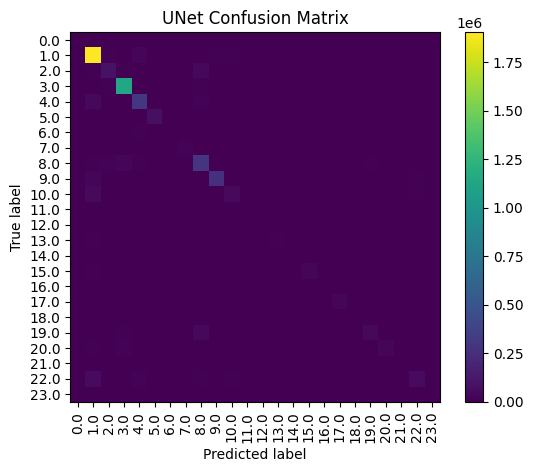

dice_class_0: 0.0
dice_class_1: 0.916310836178974
dice_class_2: 0.5674554423049617
dice_class_3: 0.941877723898666
dice_class_4: 0.7710972443679992
dice_class_5: 0.8706077078739577
dice_class_6: 0.29895468887505633
dice_class_7: 0.9242915066612318
dice_class_8: 0.6979656174209005
dice_class_9: 0.8495407685410231
dice_class_10: 0.4325016105531223
dice_class_11: 0.33429310142202373
dice_class_12: 0.0
dice_class_13: 0.23594587230950867
dice_class_14: 0.0029411764705882353
dice_class_15: 0.5370150124542782
dice_class_16: 0.0
dice_class_17: 0.84159481028309
dice_class_18: 0.4840470972774208
dice_class_19: 0.5365502803162147
dice_class_20: 0.4862962441558057
dice_class_21: 0.6613009002563643
dice_class_22: 0.3793757569045773
dice_class_23: 1.0
mean_dice: 0.5320818082719069

====== ResUNet ======
accuracy: 0.8018747329711914
precision_macro: 0.4567446739087598
recall_macro: 0.4320882993031623
f1_macro: 0.43780232292413124


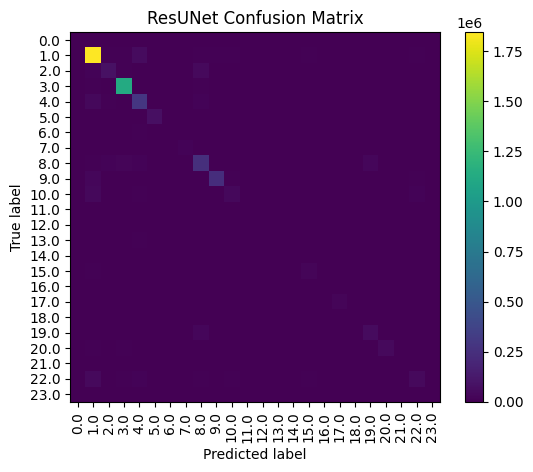

dice_class_0: 0.000468384074941452
dice_class_1: 0.9030202575293467
dice_class_2: 0.5309775111784243
dice_class_3: 0.9411034071702918
dice_class_4: 0.7082990084090504
dice_class_5: 0.8230848180215269
dice_class_6: 0.21954273166785446
dice_class_7: 0.8259904514615964
dice_class_8: 0.6477320569204164
dice_class_9: 0.8275456271137877
dice_class_10: 0.3608410542063489
dice_class_11: 0.2592648388068695
dice_class_12: 0.0
dice_class_13: 0.15705250060484569
dice_class_14: 0.0
dice_class_15: 0.4543485550128232
dice_class_16: 0.0
dice_class_17: 0.6772055586996164
dice_class_18: 0.3222401206429722
dice_class_19: 0.5385494927767016
dice_class_20: 0.6303834808259587
dice_class_21: 0.3430788567681294
dice_class_22: 0.33652703828764763
dice_class_23: 1.0
mean_dice: 0.4794689895907979

====== Segformer ======
accuracy: 0.7598735809326171
precision_macro: 0.4657415253682127
recall_macro: 0.3787611962449103
f1_macro: 0.4054996261360986


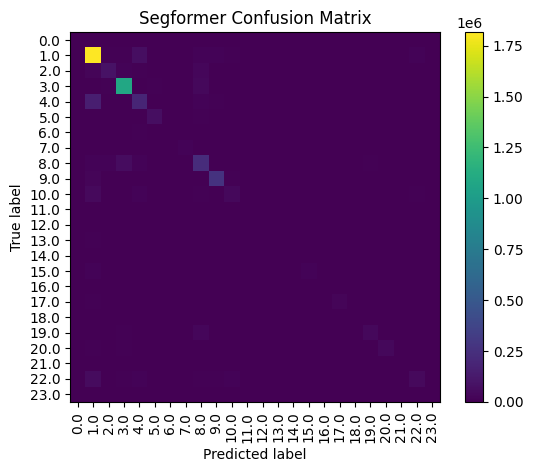

dice_class_0: 0.0
dice_class_1: 0.8639869393440132
dice_class_2: 0.5436158927845388
dice_class_3: 0.9083101440575732
dice_class_4: 0.5066373556592084
dice_class_5: 0.7376391551610253
dice_class_6: 0.18828328611898018
dice_class_7: 0.8508117126173721
dice_class_8: 0.5781037540738221
dice_class_9: 0.8508878172898683
dice_class_10: 0.30136000226464843
dice_class_11: 0.3437224863532312
dice_class_12: 0.0
dice_class_13: 0.12663190347505043
dice_class_14: 0.0011788977306218685
dice_class_15: 0.3762070658654633
dice_class_16: 0.0
dice_class_17: 0.6595666318826345
dice_class_18: 0.22884425419822194
dice_class_19: 0.5069102167182663
dice_class_20: 0.5697281312459599
dice_class_21: 0.28019323671497587
dice_class_22: 0.30937214371089083
dice_class_23: 1.0
mean_dice: 0.44716629280276526

====== DeepLabV3 ======
accuracy: 0.8258293151855469
precision_macro: 0.5533568212432926
recall_macro: 0.4866062759656928
f1_macro: 0.5135432900346114


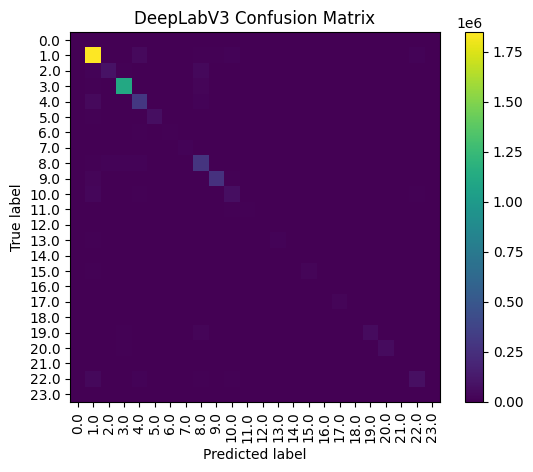

dice_class_0: 0.0007417022065640646
dice_class_1: 0.9074064475429959
dice_class_2: 0.5794025108252079
dice_class_3: 0.9397800679507438
dice_class_4: 0.7257445181809842
dice_class_5: 0.8217995333578103
dice_class_6: 0.3408223070775242
dice_class_7: 0.8984415139578695
dice_class_8: 0.7072148486916205
dice_class_9: 0.8505033243003507
dice_class_10: 0.49989818548013876
dice_class_11: 0.3541651888108581
dice_class_12: 0.0
dice_class_13: 0.39832613749584855
dice_class_14: 0.0
dice_class_15: 0.5218017214286439
dice_class_16: 0.0
dice_class_17: 0.8317479103483986
dice_class_18: 0.4981511836236801
dice_class_19: 0.6422678937580468
dice_class_20: 0.7608428023602994
dice_class_21: 0.5611723581607959
dice_class_22: 0.48480880527229264
dice_class_23: 1.0
mean_dice: 0.555209956701278


In [ ]:
models_predictions = {
    "UNet": unet_prediction,
    "ResUNet": resUnet_prediction,
    "Segformer": segformer_prediction,
    "DeepLabV3": deeplabv3_prediction,
}

for name, prediction in models_predictions.items():
    print(f"\n====== {name} ======")
    metrics, dice = evaluate_model(y_true, prediction,df_label)

    for k, v in metrics.items():
        if k != "confusion_matrix":
            print(f"{k}: {v}")
        else:
          ConfusionMatrixDisplay(v,
                                 display_labels=df_label['label'].unique(),
                                 ).plot(include_values=False)

          plt.title(f"{name} Confusion Matrix")
          plt.xticks(rotation=90)
          plt.show()
    for k, v in dice.items():
        print(f"{k}: {v}")

47


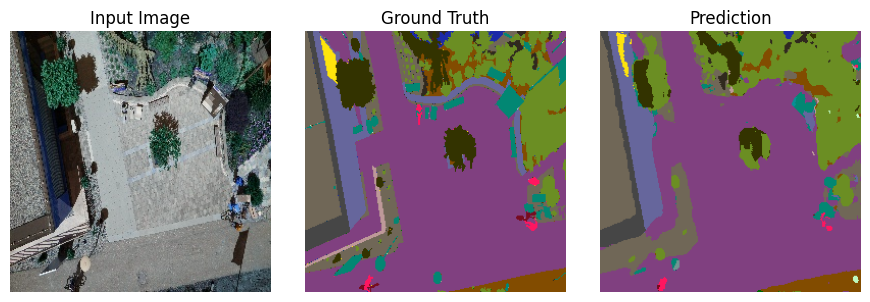

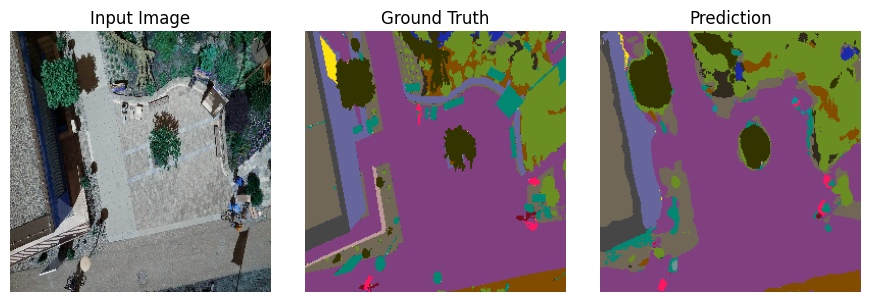

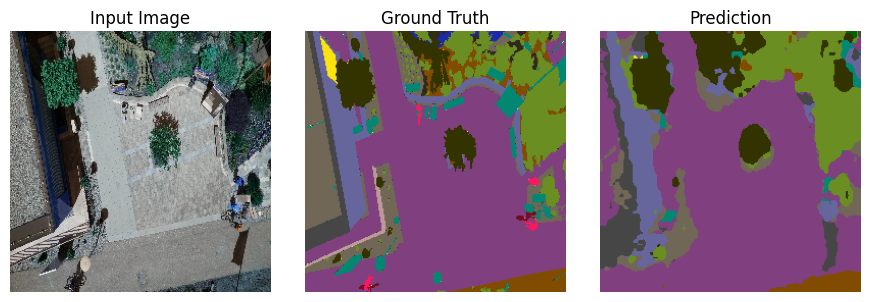

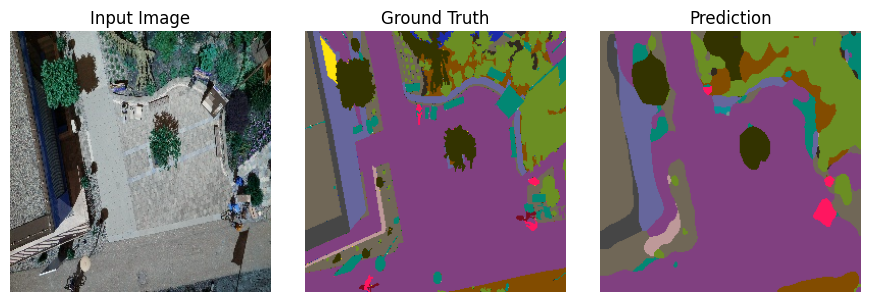

In [ ]:
input_images = []
for batch in test_dataset:
    img, _ = batch
    input_images.append(img.numpy().squeeze())

input_images = np.stack(input_images)  # shape (80, 256, 256, 3)
i=random.randint(0,80)
print(i)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=unet_prediction,
    data=df_label,
    index=i
)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=resUnet_prediction,
    data=df_label,
    index=i
)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=segformer_prediction,
    data=df_label,
    index=i
)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=deeplabv3_prediction,
    data=df_label,
    index=i
)


## Best spot to land

To find the best spot where the drone can land I do the following step:

1. I define a **score metric** based on the best semantic region
2. I **map each pixel** to this function score
3. I **clusterized** this new matrix of score by using a **hierarchical agglomerative clustering** algorithm
4. The best spot will be the cluster with the **best mean score**

### Score function

As a scoring function, I have different options, such as using the Hamming distance or defining a custom score, etc.
However, since the label assigned to each semantic zone seems meaningful, I decided to "normalize"/map the values using a Gaussian centered on the label of the best zone: **paved-area**.

$$
\text{score}(x) = \exp\left(-\left( \frac{x - \mu}{2\sigma} \right)^2\right)
$$

In [ ]:
labels = df_label[['name','label']]
labels['label'].astype(int)

mu = df_label.loc[df_label['name']=='paved-area','label'].values[0]
sigma = np.std(labels['label'])

print(f"media:{mu}")
print(f"deviazione standard:{sigma}")

media:1.0
deviazione standard:6.922186552431729


Score definition

In [ ]:
score_map = {}
for row in labels.iterrows():
    name = row[1]['name']
    val = row[1]['label']
    score_map[name] = gaussian_score(val, mu, sigma)

for k,v in score_map.items():
    print(f"{k}: {v:.4f}")


unlabeled: 0.9948
paved-area: 1.0000
dirt: 0.9948
grass: 0.9793
gravel: 0.9541
water: 0.9199
rocks: 0.8777
pool: 0.8288
vegetation: 0.7744
roof: 0.7161
wall: 0.6553
window: 0.5935
door: 0.5319
fence: 0.4718
fence-pole: 0.4141
person: 0.3597
dog: 0.3092
car: 0.2630
bicycle: 0.2214
tree: 0.1844
bald-tree: 0.1521
ar-marker: 0.1241
obstacle: 0.1002
conflicting: 0.0800


Map each pixel to this score

36


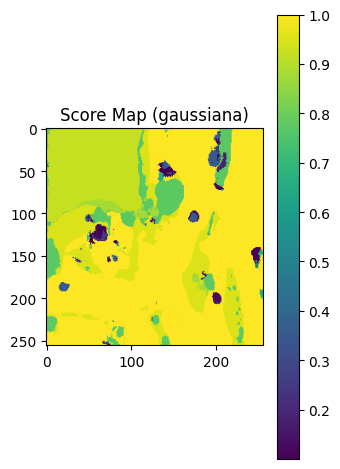

In [ ]:
i=random.randint(0,80)
print(i)
h, w = resUnet_prediction[i].shape
score_map_img = np.zeros((h, w), dtype=float)

for y in range(h):
    for x in range(w):
        val = resUnet_prediction[0][y, x]
        class_name = labels.loc[labels['label'] == val, 'name'].values[0]
        if class_name is None:
            score_map_img[y, x] = 0.0
        else:
            score_map_img[y, x] = score_map[class_name]

plt.subplot(1,2,2)
plt.title("Score Map (gaussiana)")
plt.imshow(score_map_img, cmap='viridis')
plt.colorbar()
plt.tight_layout()
plt.show()

### Clustering

In [ ]:
# Array of shape (num_pixel, 3): [score, y, x]
h, w = score_map_img.shape
features = []
positions = []

for y in range(h):
    for x in range(w):
        score = score_map_img[y, x]
        features.append([score, y / h, x / w])  # normalize coordinates useless?
        positions.append((y, x))

features = np.array(features)

print(f"Features shape: {features.shape}")
#print(features)
print(f"\nPositions shape: {np.array(positions).shape}")
#print(positions)


Features shape: (65536, 3)

Positions shape: (65536, 2)


I apply clustering.
I decided to create 64 clustering beacuse in this way we will have probably zones of at least 4x4 pixels

In [ ]:
n_clusters = 64
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = clustering.fit_predict(features)

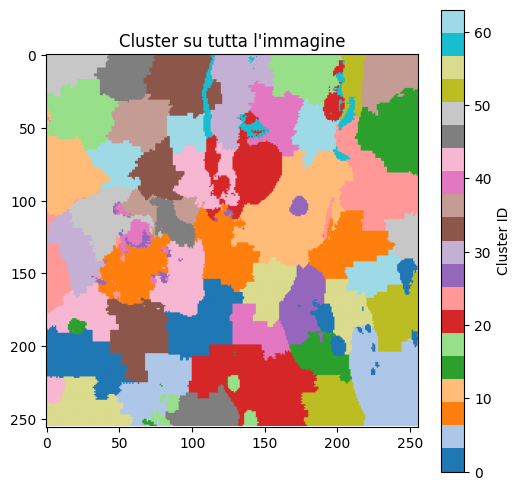

In [ ]:
cluster_image = np.zeros((h, w), dtype=int)

for idx, (y, x) in enumerate(positions):
    cluster_image[y, x] = labels[idx]

plt.figure(figsize=(6, 6))
plt.title("Cluster su tutta l'immagine")
plt.imshow(cluster_image, cmap='tab20', vmin=0, vmax=n_clusters-1)
plt.colorbar(label='Cluster ID')
plt.show()

I compute mean score for eacg cluster

In [ ]:
cluster_scores = np.zeros(n_clusters)
cluster_counts = np.zeros(n_clusters)

for idx, label in enumerate(labels):
    cluster_scores[label] += features[idx][0]  # somma score
    cluster_counts[label] += 1

# Calcolo media
for i in range(n_clusters):
    if cluster_counts[i] > 0:
        cluster_scores[i] /= cluster_counts[i]

In [ ]:
cluster_scores.shape

(64,)

I order the clusters and I show the best 5 spot

In [ ]:
cluster_score_list = []
for i, score in enumerate(cluster_scores):
    cluster_score_list.append((i, score))

# Ordinamento usando il parametro key con una funzione definita a parte
def get_score(item):
    return item[1]

sorted_clusters = sorted(cluster_score_list, key=get_score, reverse=True)
print(sorted_clusters)

[(2, np.float64(1.0)), (8, np.float64(1.0)), (13, np.float64(1.0)), (24, np.float64(1.0)), (35, np.float64(1.0)), (40, np.float64(1.0)), (48, np.float64(1.0)), (52, np.float64(1.0)), (53, np.float64(1.0)), (56, np.float64(1.0)), (62, np.float64(1.0)), (34, np.float64(0.9999426050989918)), (17, np.float64(0.9999181982956467)), (60, np.float64(0.9998314998598915)), (20, np.float64(0.9996794888665268)), (47, np.float64(0.99896588742484)), (55, np.float64(0.9982845505068417)), (39, np.float64(0.9981562105912527)), (6, np.float64(0.9980456076658669)), (46, np.float64(0.9978741086195513)), (44, np.float64(0.9973527546960541)), (12, np.float64(0.9956668975115064)), (30, np.float64(0.994498999071619)), (0, np.float64(0.9943961983223378)), (10, np.float64(0.9909972569309419)), (21, np.float64(0.9904279923747502)), (54, np.float64(0.9889381592483897)), (31, np.float64(0.984068338279263)), (9, np.float64(0.9833666207904883)), (7, np.float64(0.9820025763518366)), (15, np.float64(0.9791283254570287

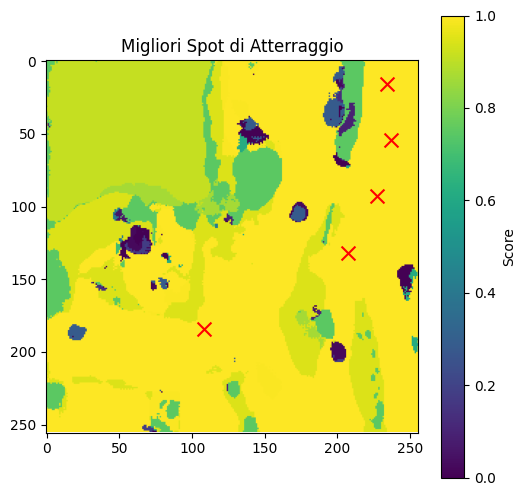

In [ ]:
top_n = 5
best_spot_coords = []

for cluster_id, _ in sorted_clusters[:top_n]:
    pixels_in_cluster = [positions[i] for i in range(len(positions)) if labels[i] == cluster_id]
    # Calcoliamo il centroide
    ys = [p[0] for p in pixels_in_cluster]
    xs = [p[1] for p in pixels_in_cluster]
    centroid_y = int(np.mean(ys))
    centroid_x = int(np.mean(xs))
    best_spot_coords.append((centroid_y, centroid_x))

plt.figure(figsize=(6, 6))
plt.title("Migliori Spot di Atterraggio")
plt.imshow(score_map_img, cmap='viridis')
for (y, x) in best_spot_coords:
    plt.scatter(x, y, color='red', s=100, marker='x', label='Best spot')
plt.colorbar(label='Score')
plt.show()

## More analysis

In [ ]:
wandb.init(project="Environment-Segmentation", job_type="load-artifact")

artifact = wandb.use_artifact('')
artifact_dir = artifact.download()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $artifact_dir